In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pandas import json_normalize
import numpy as np
from pitch import Pitch 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)



In [79]:
def load_file(match_id):
    resp = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json")
    match_dict = json.loads(resp.text)
    df = json_normalize(match_dict, sep="_")
    df = df.query("location == location")
    df[['x','y']] = pd.DataFrame(df.location.values.tolist(), index= df.index)
    #Reversing the y-axis co-ordinates because Statsbomb use this reversed co-ordinate system
    df['y'] = 80 - df['y'] 
    df['location'] = df[['x', 'y']].apply(list, axis=1)
    return match_dict, df

match_dict, df = load_file(match_id=16120)

In [ ]:
side_dict = {"home": match_dict[0]["team"]["name"],
             "away": match_dict[1]["team"]["name"] }

print(side_dict)

In [65]:
side = "home"
lineups = get_starters(match_dict, side=side)

In [67]:
class Player:
    def __init__(self, player, df):
        self.id = player["player"]["id"]
        self.name = player["player"]["name"]
        self.average_position(df)

    def average_position(self, df):

        player_pass_df = df.query("(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) & (player_id == @self.id) & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
        self.x, self.y = np.mean(player_pass_df['location'].tolist(), axis=0)

        self.n_passes_completed = len(player_pass_df)


In [68]:
player_objs_dict = {}
starters = []
for player in lineups:
    starters.append(player["player"]["name"]) ##To remove all substitutes from our final grouped_df
    p = Player(player, df) ##Calling the Player class
    player_objs_dict.update({player["player"]["name"]: p}) ##For lookup during plotting the grouped_df

In [70]:
min_pass_count = 2
total_pass_df = df.query(f"(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) &"\
                                 f"(team_name == '{side_dict[side]}') & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
total_pass_df = total_pass_df.groupby(["player_name", "pass_recipient_name"]).size().reset_index(name="count")
total_pass_df = total_pass_df.query(" (player_name == @starters) & (pass_recipient_name == @starters) & (count>=@min_pass_count) ")

In [72]:
total_pass_df

,player_name,pass_recipient_name,count
1,Damián Nicolás Suárez Suárez,Dimitri Foulquier,2
2,Damián Nicolás Suárez Suárez,Francisco Portillo Soler,2
8,Damián Nicolás Suárez Suárez,Vitorino Gabriel Pacheco Antunes,2
9,Damián Nicolás Suárez Suárez,Ángel Luis Rodríguez Díaz,3
12,David Soria Solís,Jaime Mata Arnaiz,4
14,Dimitri Foulquier,Damián Nicolás Suárez Suárez,3
16,Dimitri Foulquier,Jaime Mata Arnaiz,2
18,Dimitri Foulquier,Ángel Luis Rodríguez Díaz,3
19,Djené Dakonam Ortega,Damián Nicolás Suárez Suárez,5
20,Djené Dakonam Ortega,David Soria Solís,4


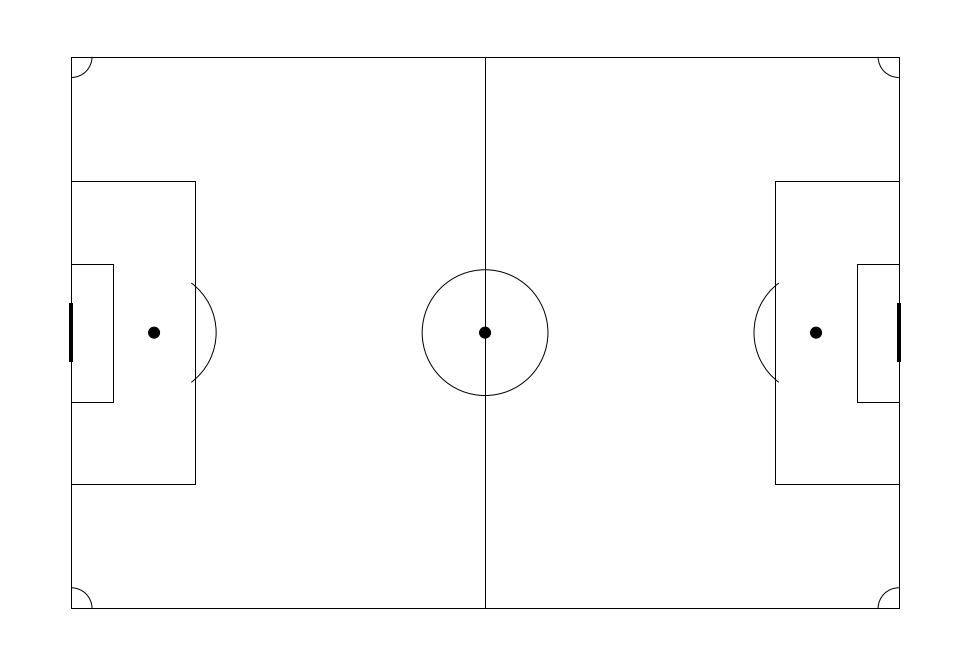

In [73]:
plt.rcParams["figure.figsize"] = (20,12)
fig, ax = plt.subplots()
ax = Pitch(ax)


In [ ]:
marker_color = "green"
player_color = "red"
side_color = "blue"

In [74]:
arrow_shift = 1 ##Units by which the arrow moves from its original position
shrink_val = 1.5 ##Units by which the arrow is shortened from the end_points

##Visualising the passmap

for row in total_pass_df.itertuples():

    link = row[3] ## for the arrow-width and the alpha
    passer = player_objs_dict[row[1]]
    receiver = player_objs_dict[row[2]]

    alpha = link/15
    if alpha >1:
        alpha=1

    if abs( receiver.x - passer.x) > abs(receiver.y - passer.y):

        if receiver.id > passer.id:
            ax.annotate("", xy=(receiver.x, receiver.y + arrow_shift), xytext=(passer.x, passer.y + arrow_shift),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw = link*0.12, alpha=alpha))

        elif passer.id > receiver.id:
            ax.annotate("", xy=(receiver.x, receiver.y - arrow_shift), xytext=(passer.x, passer.y - arrow_shift),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

    elif abs(receiver.x - passer.x) <= abs(receiver.y - passer.y):

        if receiver.id > passer.id:
            ax.annotate("", xy=(receiver.x + arrow_shift, receiver.y), xytext=(passer.x + arrow_shift, passer.y),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

        elif passer.id > receiver.id:
            ax.annotate("", xy=(receiver.x - arrow_shift, receiver.y), xytext=(passer.x - arrow_shift, passer.y),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

In [75]:
for name, player in player_objs_dict.items():

    ax.scatter(player.x, player.y, s=player.n_passes_completed*1.3, color=marker_color, zorder = 4)
    ax.text(player.x, player.y+2 if player.y >40 else player.y -2, s=player.name.split(" ")[-2], rotation=270, va="top" if player.y<40 else "bottom", size=13, fontweight="book", zorder=7, color=player_color)

ax.text(124, 80, f"{side_dict[side]}", size=24, fontweight="demibold", rotation=270, color=side_color, va="top")
ax.text(122, 80, f"{side_dict['home']} vs {side_dict['away']}", size=16, fontweight="demibold", rotation = 270, va="top")

fig.tight_layout()

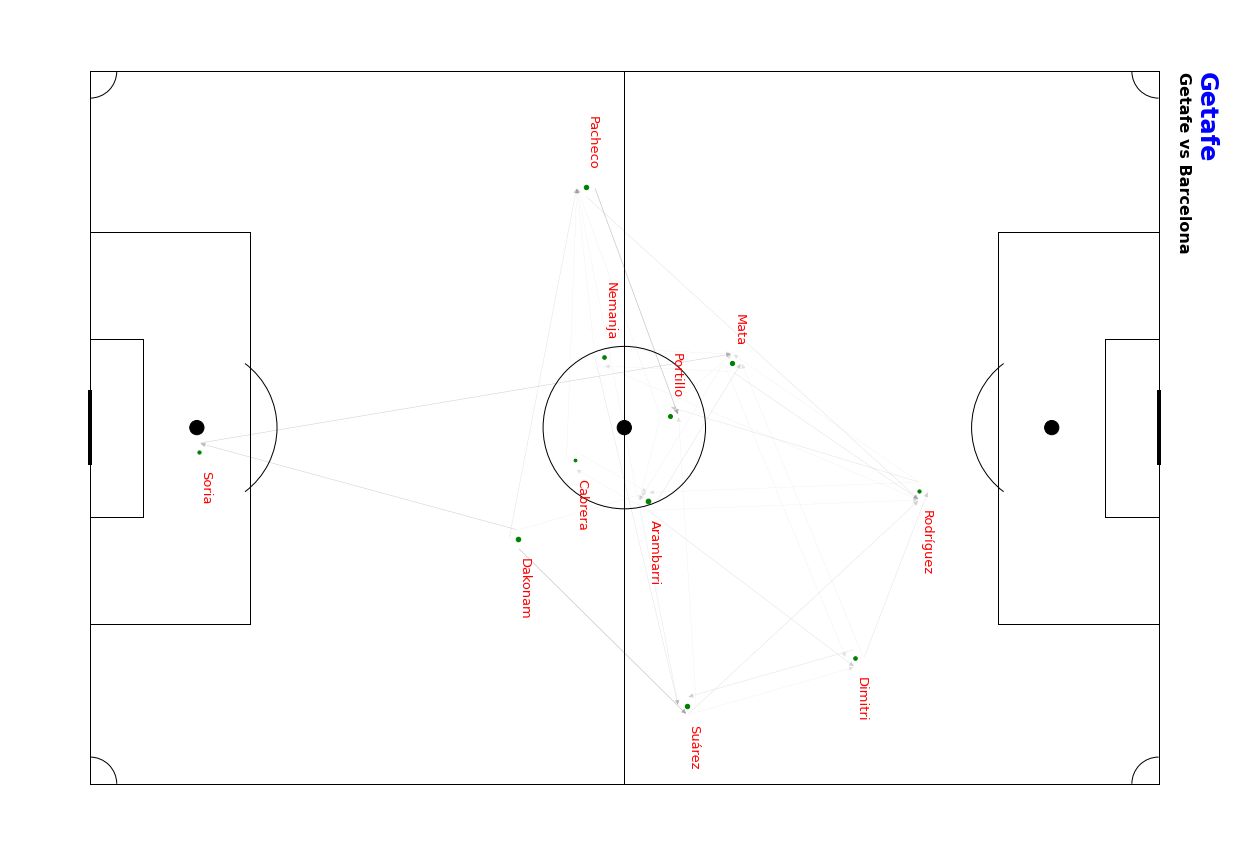

In [76]:
fig.tight_layout()
fig.savefig('./pass_plot.jpg')
fig